# Space Occupation

The concept of space occupation in soccer is an important one. Occupying key areas on the pitch, for instance in the box of the opponent, can lead to more chances and goals. In this notebook, I will show how to calculate the space occupation of a team on the pitch using tracking data. We will go over 2 different models. The first model is a simple Voronoi approach and the second model is a more advanced model that uses a Gaussian distrubtion to calculate the space occupation based on a paper of Fernandez & Born (2018).

## Voronoi Model

Voronoi models are fairly simple: every location on the pitch is awarded to the player closest to that location. It is intuitive and very explainable. The Voronoi model is based on the Voronoi diagram, which is a partitioning of a plane into regions based on distance to a specific set of points. In this case, the points are the players on the pitch. However, computationally it is not that easy to solve the Voronoi diagram. We will use the `scipy` library to calculate the Voronoi diagram. In this codebase we will make use of an approximation approach over an exact approach for computational reasons. The exact approach is very slow and not feasible for real-time applications. Instead, we will use the KDTree approach to approximate the Voronoi diagram. In this approach, we create a grid of points on the pitch and assign each point to the closest player. The KDTree approach is much faster than the exact approach and is good enough for our purposes.

```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()
```

```{note}
The current supported tracking data providers are:

- Tracab
- Metrica
- Inmotio

The current supported event data provider are:
- Opta
- Metrica
- Instat

If you wish to use a different provider that is not listed here, please open an issue [here](https://github.com/Alek050/databallpy/issues)
```

In [27]:
from databallpy import get_saved_match
import os

match = get_saved_match("synced_match", os.path.join(os.getcwd(), "../saved_matches"))

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from databallpy.visualize import plot_soccer_pitch, plot_tracking_data
from databallpy.features import add_velocity

from scipy.spatial import KDTree

def get_approximate_voronoi(
        tracking_data: pd.Series | pd.DataFrame, 
        pitch_dimensions: list[float, float], 
        n_x_bins: int = 106, 
        n_y_bins: int = 68) -> tuple[np.ndarray, np.ndarray]:
    """Find the nearest player to each cell center in a grid of cells covering the pitch.

    Args:
        tracking_data (pd.Series | pd.DataFrame): The tracking data. If it is a pd.Series, it is assumed that
            it contains data of a single frame. If it is a pd.DataFrame it is assumed that it contains
            tracking data of multiple frames.
        pitch_dimensions (list[float, float]): The dimensions of the pitch.
        n_x_bins (int, optional): The number of cells in the width (x) direction. Defaults to 106.
        n_y_bins (int, optional): The number of cells in the height (y) direction. Defaults to 68.

    Returns:
        tuple[np.ndarray, np.ndarray]: The distances to the nearest player for each cell center and the column ids of the nearest player.
            If tracking_data is a pd.Series, the shape will be (n_y_bins x n_x_bins), otherwise (len(tracking_data) x n_y_bins x n_x_bins).
    """
    pitch_length, pitch_width = pitch_dimensions
    x_bins = np.linspace(-pitch_length / 2, pitch_length / 2, n_x_bins + 1)
    y_bins = np.linspace(-pitch_width / 2, pitch_width / 2, n_y_bins + 1)
    cell_centers_x, cell_centers_y = np.meshgrid(x_bins[:-1] + np.diff(x_bins) / 2, y_bins[:-1] + np.diff(y_bins) / 2)


    if isinstance(tracking_data, pd.Series):
        tracking_data = tracking_data.to_frame().T

    all_distances = np.empty((len(tracking_data), n_y_bins, n_x_bins), dtype=np.float32)
    all_assigned_players = np.empty((len(tracking_data), n_y_bins, n_x_bins), dtype="U7")
    for i, (_, frame) in enumerate(tracking_data.iterrows()):
        player_column_ids = np.array(
            [column[:-2] for column in frame.index if column[-2:] in ["_x", "_y"] and not pd.isnull(frame[column]) and not "ball" in column]
            )
        player_positions = np.array([[frame[column + "_x"], frame[column + "_y"]] for column in player_column_ids]).astype(np.float64)

        tree = KDTree(player_positions)
        cell_centers = np.column_stack((cell_centers_x.ravel(), cell_centers_y.ravel()))
        distances, nearest_player_indices = tree.query(cell_centers)
        
        all_assigned_players[i] = player_column_ids[nearest_player_indices].reshape(n_y_bins, n_x_bins)
        all_distances[i] = distances.reshape(n_y_bins, n_x_bins)

    if all_distances.shape[0] == 1:
        all_distances = all_distances[0]
        all_assigned_players = all_assigned_players[0]

    return all_distances, all_assigned_players

frame = match.tracking_data.iloc[200]

distances, nearest_player_column_ids = get_approximate_voronoi(
    frame, 
    match.pitch_dimensions,
    1000,
    600
)

print(distances.shape, nearest_player_column_ids.shape)

(600, 1000) (600, 1000)


For ever cell in the grid, we now have the player (column_id) that is closest to that cell, and the distance that the player is to that cell. We can continue in different ways. For instance, you could calculate which players have the most cells assigned to them, or you can give each cell a different value based on the location of the cell, and see who has the most value assigned to them. In this notebook, just plot the voronoi diagram.

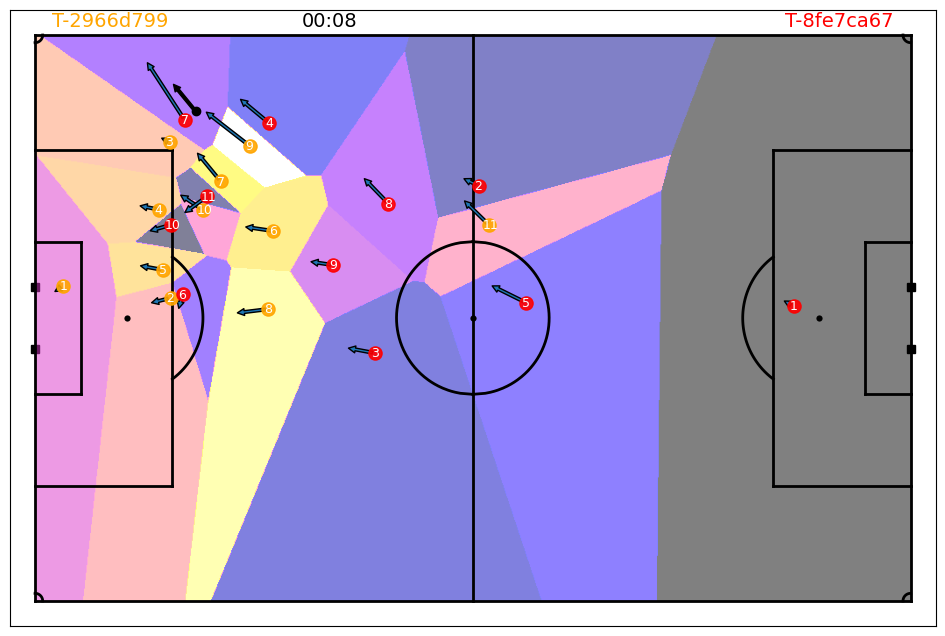

away_1 occupied 1981.19 m^2
away_10 occupied 22.63 m^2
away_11 occupied 15.73 m^2
away_2 occupied 591.69 m^2
away_3 occupied 949.90 m^2
away_4 occupied 242.42 m^2
away_5 occupied 899.00 m^2
away_6 occupied 62.08 m^2
away_7 occupied 170.17 m^2
away_8 occupied 210.69 m^2
away_9 occupied 104.44 m^2
home_1 occupied 388.83 m^2
home_10 occupied 31.51 m^2
home_11 occupied 190.23 m^2
home_2 occupied 422.74 m^2
home_3 occupied 183.06 m^2
home_4 occupied 99.13 m^2
home_5 occupied 48.81 m^2
home_6 occupied 93.24 m^2
home_7 occupied 32.66 m^2
home_8 occupied 325.59 m^2
home_9 occupied 46.50 m^2


In [79]:
cat_dict = {string:i for i, string in enumerate(np.unique(nearest_player_column_ids))}
categories = np.vectorize(cat_dict.get)(nearest_player_column_ids)

match.tracking_data = add_velocity(
    match.tracking_data, 
    match.home_players_column_ids()+match.away_players_column_ids(), 
    match.frame_rate,
    filter_type="savitzky_golay",
    )

fig, ax = plot_soccer_pitch(field_dimen=match.pitch_dimensions, pitch_color="white")
fig, ax = plot_tracking_data(match, 200, team_colors=["orange", "red"], ax=ax, fig=fig, add_velocities=True)
ax.imshow(
    categories, 
    extent=(-match.pitch_dimensions[0]/2, match.pitch_dimensions[0]/2, -match.pitch_dimensions[1]/2, match.pitch_dimensions[1]/2), 
    alpha=0.5, 
    cmap="gnuplot2", 
    origin="lower", 
    zorder=-3
)
plt.show()

area_per_cell = (match.pitch_dimensions[0] / 1000) * (match.pitch_dimensions[1] / 600)
column_ids, num_cells = np.unique(nearest_player_column_ids, return_counts=True)

space_per_player = {column_id: cells * area_per_cell for column_id, cells in zip(column_ids, num_cells)}
for key, val in space_per_player.items():
    print(f"{key} occupied {val:.2f} m^2")


And there it is! Depending on the number of x and y bins, you get a more fine grained result. The Voronoi model is a good starting point to understand space occupation in soccer.

## Gaussian Model (Fernandez & Born, 2018)

Although the voronoi is a great start for space ocupation, it ignores the fact that players are in fact moving. When you are running at a high velocity, you might be able to reach a certain area of the pitch faster than when you are walking. On top of that, you might not be able to reach the space directly behind you that easily. The gaussian model of Fernandez & Born (Wide Open Spaces: a Statistical Technique for Measuring Space Creation in Professional Soccer, 2018) takes this in to account by using a gaussian distribution to calculate the space occupation. The model is based around the idea that every has a certain influence on the space around them. The influence of a player is based on the distance to the ball, and the velocity of the player. 

Before implementing the player influence, we need some helper functions:

1. `get_pitch_control_surface_radius`: this function calculates the radius of the pitch control surface based on the distance to the ball. (figure 19 in the article)

2. `get_scaling_matrix`: this function calculates the scaling matrix based on the velocity of the player and the pitch control surface radius. (formula 19 in the article)

3. `get_covariance_matrix`: this function calculates the covariance matrix based on the scaling matrix and the velocity vector of the player. (formula 16, 17, and 20 in the article)

4. `get_mean_position_of_influence`: this function calculates the mean of the player influence based on the locations and the velocity vector of the player. (formula 21 in the article)

In [87]:
def get_pitch_control_surface_radius(
    distance_to_ball: float, min_r: float = 4.0, max_r: float = 10.0
) -> float:
    """
    Calculate the pitch control surface radius based on the distance to the ball.
    Note that the article does not provide the mathematical function for this formula,
    only a figure (Figure 9 in Appendix 1.). The constants (0.00025 and 3.5) are
    obtained by visual inspection. The value is refered to as R_i(t) in the article.

    Args:
        distance_to_ball (float): Distance from the player to the ball.
        min_r (float, optional): The minimal influence radius of a player.
            Defaults to 4.0.
        max_r (float, optional): The maximal influence radius of a player.
            Defaults to 10.0

    Returns:
        float: Pitch control surface radius.
    """
    val = min_r + 0.00025 * np.power(distance_to_ball, 3.5)
    return min(val, max_r) 

````{margin}
```{note}
This formula is obtained by visual inspection of the figure given in the appendix of the article since I could not find the mathematical equation. If you know the exact equation, please let me know so we can improve the code
```
````

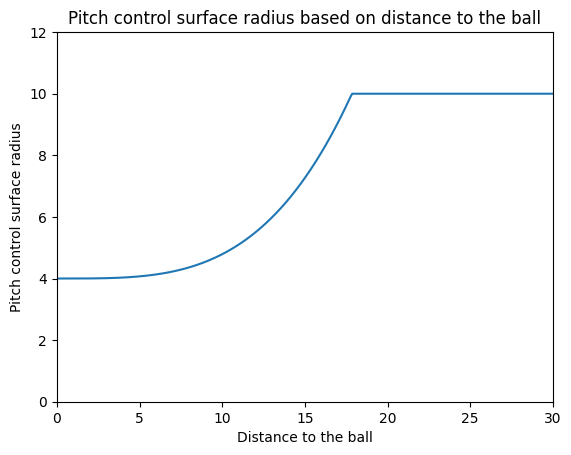

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(0, 30, 300)
y = [get_pitch_control_surface_radius(val) for val in x]
ax.set_xlim(0, 30)
ax.set_ylim(0, 12)
ax.set_xlabel("Distance to the ball")
ax.set_ylabel("Pitch control surface radius")
ax.set_title("Pitch control surface radius based on distance to the ball")
plt.plot(x, y)
plt.show()

````{margin}
```{note}
In the formula, it states that alle elements in the scaling matrix should be divided by 2. However, if I do so, the influence areas of the players become about twice a s small when comparing to figure 1 in the paper. Therefore I did not do that. Have you spotted my mistake in calculating the influence area? Please let me know via Github!
```
````

In [84]:
def calculate_scaling_matrix(
    speed_magnitude: float,
    distance_to_ball: float,
    max_speed: float = 13.0,
) -> np.ndarray:
    """
    Calculate the scaling factors using the statistical technique presented in the
    article "Wide Open Spaces" by Fernandez & Born (2018).
    Determines the scaling factors based on the player's speed magnitude and the
    distance to the ball. The range of the player's pitch control surface radius is
    defined, and scaling factors are calculated. The scaling matrix is then expanded
    in the x direction and contracted in the y direction using these factors.

    This is formula 19 in the appendix, where S_i(t) is defined.

    Args:
        speed_magnitude (float): Magnitude of the player's speed in m/s.
        distance_to_ball (float): Distance from the player to the ball in meters.
        max_speed (float, optional): Max speed a player can have in m/s.
            Defaults to 13.0.

    Returns:
        np.ndarray: Scaling matrix.
    """

    # Refered to as R_i(t) in the article
    influence_radius = get_pitch_control_surface_radius(distance_to_ball)
    ratio_of_max_speed = np.power(min(speed_magnitude, max_speed), 2) / np.power(max_speed, 2)

    return np.array(
        [
            [(influence_radius + (influence_radius * ratio_of_max_speed)), 0],
            [0, (influence_radius - (influence_radius * ratio_of_max_speed))],
        ]
    )

def calculate_covariance_matrix(
    vx_val: float,
    vy_val: float,
    scaling_matrix: np.ndarray,
) -> np.ndarray:
    """
    Calculate the covariance matrix using the statistical technique presented in the
    article "Wide Open Spaces" by Fernandez & Born (2018).
    It dynamically adjusts the covariance matrix to provide a player dominance
    distribution that considers both location and velocity. The method involves the
    singular value decomposition (SVD) algorithm, expressing the covariance matrix
    in terms of eigenvectors and eigenvalues. The rotation matrix and scaling
    matrix are then derived, incorporating the rotation angle of the speed vector
    and scaling factors in the x and y directions.

    The calculated value is COV_i(t) as defined in formula 20 of the appendix.

    Args:
        vx_val (float): Velocity of the player in the x-direction in m/s.
        vy_val (float): Velocity of the player in the y-direction in m/s.
        scaling_matrix (np.ndarray): 2 by 2 array based on the velocity of a
            player and its distance to the ball. Determines the spread af the
            covariance matrix.

    Returns:
        np.ndarray: Covariance matrix.
    """
    rotation_angle = np.arctan2(vy_val, vx_val)
    rotation_matrix = np.array(
        [
            [np.cos(rotation_angle), -np.sin(rotation_angle)],
            [np.sin(rotation_angle), np.cos(rotation_angle)],
        ]
    )

    covariance_matrix = np.dot(np.dot(np.dot(rotation_matrix, scaling_matrix), scaling_matrix), np.linalg.inv(rotation_matrix))

    return covariance_matrix

def get_mean_position_of_influence(
    x_val: float,
    y_val: float,
    vx_val: float,
    vy_val: float,
) -> list[float]:
    """
    Calculate the mean position of player influence over time using the statistical
    technique presented in the article "Wide Open Spaces" by Fernandez & Born (2018).
    It considers the player's current position, velocity, and a specified time step.
    The mean position is obtained by translating the player's location at a given
    time by half the magnitude of the speed vector.

    This refers to u_i(t) definedin formula 21 of the appendix.

    Args:
        x_val (float): x-coordinate of the player's current position in meters.
        y_val (float): y-coordinate of the player's current position in meters.
        vx_val (float): Velocity of the player in the x-direction in m/s.
        vy_val (float): Velocity of the player in the y-direction in m/s.

    Returns:
        List[float]: Mean position [x, y] of the player's influence.
    """
    return np.array([x_val + 0.5 * vx_val, y_val + 0.5 * vy_val])

### Player Influence

Now that we have the helper functions, we can calculate the space occupation of a team based on the player influence. The player influence is now simply calculated by creating a gaussian distribution based on the mean position and the covariance matrix. Lastly, the values of the guassian distribution are scaled so that the highest value of each player influence is 1. 

In [85]:
from scipy.stats import multivariate_normal

def get_player_influence(
    x_val: float,
    y_val: float,
    vx_val: float,
    vy_val: float,
    distance_to_ball: float,
    grid: np.ndarray,
) -> np.ndarray:
    """
    Calculate player influence across the grid based on the statistical technique
    presented in the article "Wide Open Spaces" by Fernandez & Born (2018).
    It incorporates the position, velocity, and distance to the ball of a given
    player to determine the influence degree at each location on the field. The
    bivariate normal distribution is utilized to model the player's influence,
    and the result is normalized so that the sum of the players influence over
    all cells in the grid is 1. Thus, the value in a cell in the grid is the ratio
    of influence of that player in that cell.

    Args:
        x_val (float): x-coordinate of the player's current position in meters.
        y_val (float): y-coordinate of the player's current position in meters.
        vx_val (float): Velocity of the player in the x-direction in m/s.
        vy_val (float): Velocity of the player in the y-direction in m/s.
        distance_to_ball (float): distance between the ball and the (x_val, y_val) in
            meters.
        grid (np.ndarray]): Grid created with np.meshgrid.

    Returns:
        np.ndarray: Player influence values across the grid.
    """
    mean = get_mean_position_of_influence(x_val, y_val, vx_val, vy_val)
    scaling_matrix = calculate_scaling_matrix(
        np.hypot(vx_val, vy_val), distance_to_ball
    )
    covariance_matrix = calculate_covariance_matrix(vx_val, vy_val, scaling_matrix)

    grid_size = grid[0].shape
    positions = np.vstack([grid[0].ravel(), grid[1].ravel()]).T

    distribution = multivariate_normal(mean=mean, cov=covariance_matrix)
    influence_values = distribution.pdf(positions)
    influence_values = influence_values / np.max(influence_values)
    return influence_values.reshape(grid_size[0], grid_size[1])


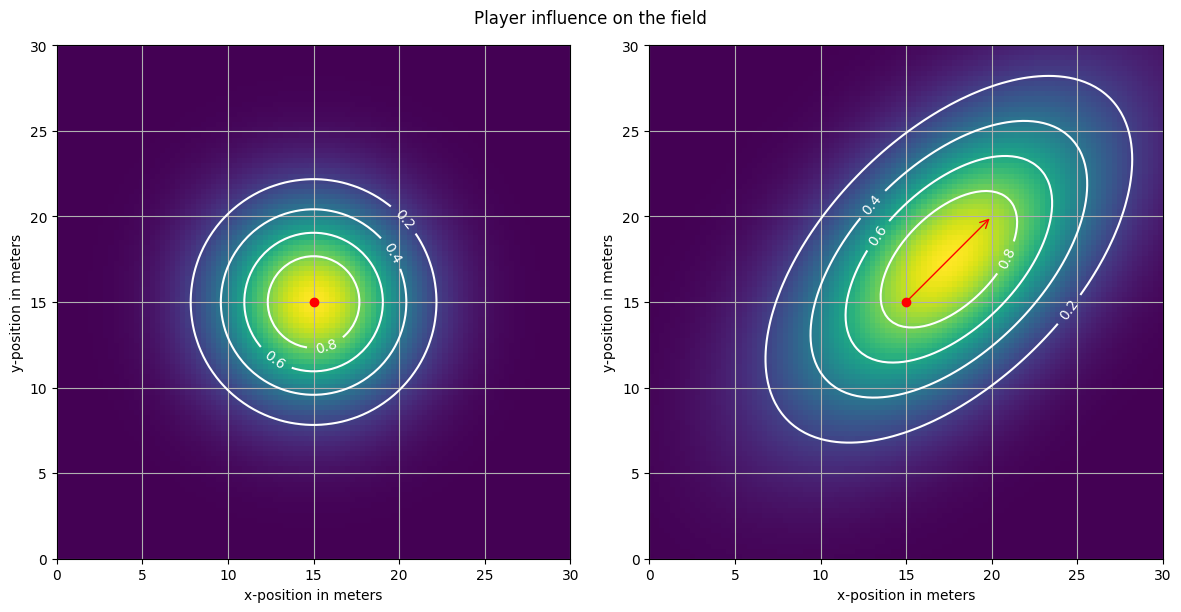

In [88]:
from matplotlib.patches import FancyArrowPatch

grid = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 30, 100))
pos = [15, 15]

vel1 = [0, 0]
dist_to_ball = 0
influence = get_player_influence(pos[0], pos[1], vel1[0], vel1[1], dist_to_ball, grid)

vel2 = [5, 5]
dist_to_ball = 12.5
influence2 = get_player_influence(pos[0], pos[1], vel2[0], vel2[1], dist_to_ball, grid)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for inf, ax, vel in zip([influence, influence2], [ax, ax2], [vel1, vel2]):
    img = ax.imshow(inf, extent=(0, 30, 0, 30), origin="lower", cmap="viridis")
    CS = ax.contour(grid[0], grid[1], inf, levels=4, colors="white")
    ax.clabel(CS, inline=1, fontsize=10)
    ax.grid(True)
    ax.scatter([pos[0]], [pos[1]], color="red", zorder=10)
    arrow = FancyArrowPatch(
        (pos[0], pos[1]),
        (pos[0] + vel[0], pos[1] + vel[1]),
        color="red",
        arrowstyle="->",
        mutation_scale=15,
    )
    ax.add_patch(arrow)
    ax.set_xlabel("x-position in meters")
    ax.set_ylabel("y-position in meters")
fig.suptitle("Player influence on the field")
fig.tight_layout()
plt.show()

### Team Influence

And there it is! The space influence of a single player is now a function of its location, distance to the ball, and velocity. Lets compute the team influence by summing the player influences. 

In [89]:
def get_team_influence(
    frame: pd.Series, col_ids: list, grid: list, player_ball_distances: pd.Series | None = None
) -> np.ndarray:
    """
    Calculate the team influence of a given team at a given frame. The team influence
    is the sum of the individual player influences of the team.

    Args:
        frame (pd.Series): Row of the tracking data.
        col_ids (list): List of column ids of the players in the team.
        grid (list): Grid created with np.meshgrid.
        player_ball_distances (pd.Series, optional): Precomputed player ball distances.

    Returns:
        np.ndarray: Team influence values across the grid.
    """
    player_influence = []
    for col_id in col_ids:
        if pd.isnull(frame[f"{col_id}_vx"]):
            continue

        if player_ball_distances is not None:
            distance_to_ball = player_ball_distances.loc[col_id]
        else:
            distance_to_ball = np.linalg.norm(
                frame[[f"{col_id}_x", f"{col_id}_y"]].values
                - frame[["ball_x", "ball_y"]].values
            )

        player_influence.append(
            get_player_influence(
                x_val=frame[f"{col_id}_x"],
                y_val=frame[f"{col_id}_y"],
                vx_val=frame[f"{col_id}_vx"],
                vy_val=frame[f"{col_id}_vy"],
                distance_to_ball=distance_to_ball,
                grid=grid,
            )
        )
    team_influence = np.sum(player_influence, axis=0)
    return team_influence

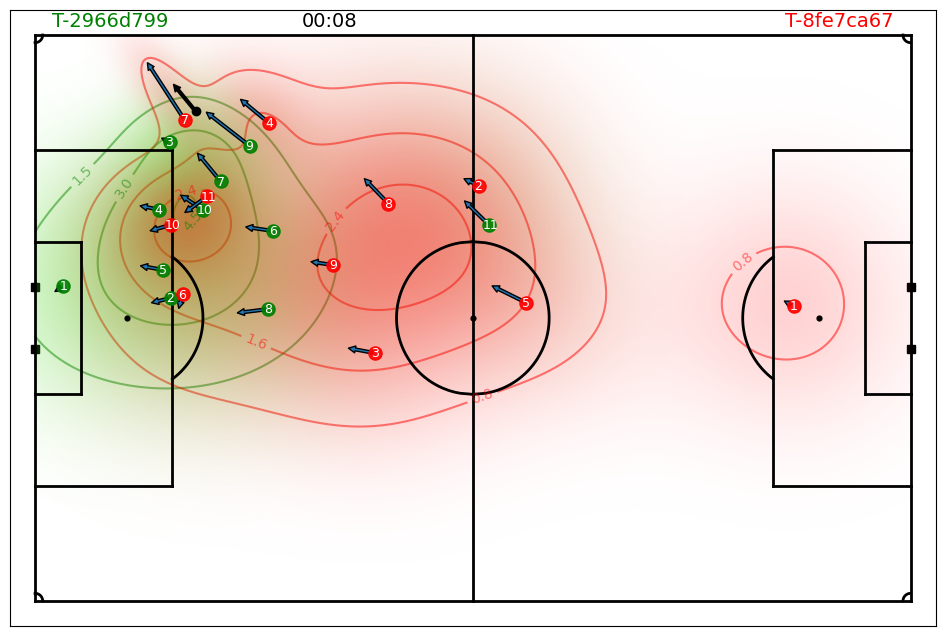

In [90]:
idx = 200

fig, ax = plot_soccer_pitch(field_dimen=match.pitch_dimensions, pitch_color="white")
fig, ax = plot_tracking_data(match, idx, team_colors=["green", "red"], ax=ax, fig=fig, add_velocities=True)

frame = match.tracking_data.iloc[idx]
grid = np.meshgrid(np.linspace(-match.pitch_dimensions[0]/2, match.pitch_dimensions[0]/2, 500), np.linspace(-match.pitch_dimensions[1]/2, match.pitch_dimensions[1]/2, 300))

home_team_influence = get_team_influence(match.tracking_data.iloc[idx], match.home_players_column_ids(), grid)
away_team_influence = get_team_influence(match.tracking_data.iloc[idx], match.away_players_column_ids(), grid)

from matplotlib.colors import LinearSegmentedColormap

cmap_red = LinearSegmentedColormap.from_list("reds", [(1, 0, 0, 0), (1, 0, 0, 1)])
cmap_green = LinearSegmentedColormap.from_list("greens", [(0, 1, 0, 0), (0, 1, 0, 1)])

ax.imshow(
    home_team_influence, 
    extent=(-match.pitch_dimensions[0]/2, match.pitch_dimensions[0]/2, -match.pitch_dimensions[1]/2, match.pitch_dimensions[1]/2), 
    alpha=0.5, 
    cmap=cmap_green, 
    origin="lower", 
    zorder=-3,
)
CS = ax.contour(grid[0], grid[1], home_team_influence, levels=3, colors="green", zorder=-4, alpha=0.5)
ax.clabel(CS, inline=1, fontsize=10)

ax.imshow(
    away_team_influence, 
    extent=(-match.pitch_dimensions[0]/2, match.pitch_dimensions[0]/2, -match.pitch_dimensions[1]/2, match.pitch_dimensions[1]/2), 
    alpha=0.5, 
    cmap=cmap_red, 
    origin="lower", 
    zorder=-3,
)
CS = ax.contour(grid[0], grid[1], away_team_influence, levels=3, colors="red", zorder=-4, alpha=0.5)
ax.clabel(CS, inline=1, fontsize=10)
plt.show()

### Pitch Control

Almost there! The last step is to compute a sigmoid function over the team influence to get the pitch control. The sigmoid function is used to normalize the team influence to a value between 0 and 1. Values close to 1 represent high pitch control by the home team, while values near 0 represent high pitch control by the away team. 

In [91]:
from databallpy.utils.utils import sigmoid

def get_pitch_control_single_frame(
    frame: pd.Series, 
    pitch_dimensions: list[float, float], 
    n_x_bins: int = 106,     
    n_y_bins: int = 68, 
    player_ball_distances: pd.Series = None
) -> np.ndarray:
    """
    Calculate the pitch control surface at a given frame. The pitch control surface
    is the sum of the team influences of the two teams. The team influence is the
    sum of the individual player influences of the team. The player influence is
    calculated using the statistical technique presented in the article "Wide Open
    Spaces" by Fernandez & Born (2018). It incorporates the position, velocity, and
    distance to the ball of a given player to determine the influence degree at each
    location on the field. The bivariate normal distribution is utilized to model the
    player's influence, and the result is normalized to obtain values within a [0, 1]
    range.
    The values are then passed through a sigmoid function to obtain the pitch control
    values within a [0, 1] range. Values near 1 indicate high pitch control by the home
    team, while values near 0 indicate high pitch control by the away team.

    Args:
        frame (pd.Series): Row of the tracking data.
        pitch_dimensions (list[float, float]): The dimensions of the pitch.
        n_x_bins (int, optional): The number of cells in the width (x) direction.
            Defaults to 106.
        n_y_bins (int, optional): The number of cells in the height (y) direction.
            Defaults to 68.
        player_ball_distances (pd.Series, optional): Precomputed player ball distances.
            Defaults to None.

    Returns:
        np.ndarray: 2D pitch control values across a 2d grid.
            Size of the grid is n_y_bins x n_x_bins.
    """

    grid = np.meshgrid(
        np.linspace(-pitch_dimensions[0] / 2, pitch_dimensions[0] / 2, n_x_bins),
        np.linspace(-pitch_dimensions[1] / 2, pitch_dimensions[1] / 2, n_y_bins),
    )

    home_col_ids = [x[:-2] for x in frame.index if "home" in x and x[-2:] == "_x"]
    away_col_ids = [x[:-2] for x in frame.index if "away" in x and x[-2:] == "_x"]

    team_influence_home = get_team_influence(
        frame,
        col_ids=home_col_ids,
        grid=grid,
        player_ball_distances=player_ball_distances,
    )
    team_influence_away = get_team_influence(
        frame,
        col_ids=away_col_ids,
        grid=grid,
        player_ball_distances=player_ball_distances,
    )
    return sigmoid(team_influence_away - team_influence_home)

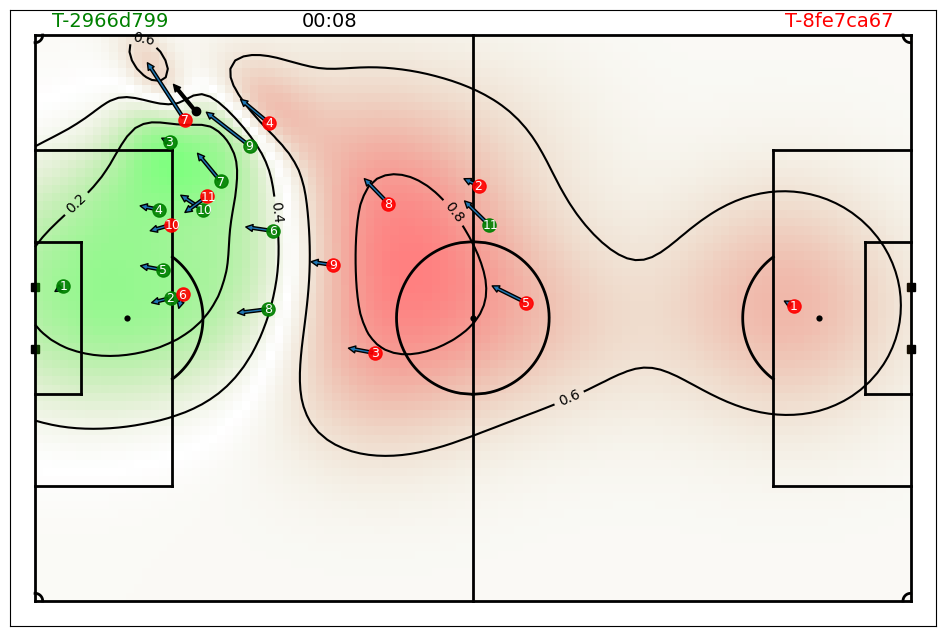

In [92]:
idx = 200

fig, ax = plot_soccer_pitch(field_dimen=match.pitch_dimensions, pitch_color="white")
fig, ax = plot_tracking_data(match, idx, team_colors=["green", "red"], ax=ax, fig=fig, add_velocities=True)

frame = match.tracking_data.iloc[idx]
pitch_control = get_pitch_control_single_frame(frame, match.pitch_dimensions, 106, 68)

cmap_red_green = LinearSegmentedColormap.from_list("reds", [(0, 1, 0, 1), (0.5, 0.5, 0, 0), (1, 0, 0, 1)])
grid = np.meshgrid(
        np.linspace(-match.pitch_dimensions[0] / 2, match.pitch_dimensions[0] / 2, 106),
        np.linspace(-match.pitch_dimensions[1] / 2, match.pitch_dimensions[1] / 2, 68),
    )
ax.imshow(
    pitch_control,
    extent=(-match.pitch_dimensions[0]/2, match.pitch_dimensions[0]/2, -match.pitch_dimensions[1]/2, match.pitch_dimensions[1]/2), 
    alpha=0.5, 
    cmap=cmap_red_green, 
    origin="lower", 
    zorder=-3,
)
CS = ax.contour(grid[0], grid[1], pitch_control, levels=3, colors="black", zorder=-2)
ax.clabel(CS, inline=1, fontsize=10)

plt.show()

Here we are! We have calculated the space occupation of a team on the pitch using tracking data. The gaussian model is a more advanced model than the voronoi model, but it is also more computationally expensive. The gaussian model is a great way to understand space occupation in soccer, and can be used to analyze the space occupation of a team during a match. There are, however, a few notes to make here. First of all, in the case of the Voronoi, every cell in the grid was awarded to a single player, making it easy to understand the influence of a single player on the space occupation. In the Gaussian model, every cell is influenced by all 22 players. Providing the information about who influences what is certainly possible, but would require to return 22 grids over the pitch for every player, which is memory expensive, so therefore we choose not to do it (challenge yourself by still getting to that if you want!). Secondly, the guassian model certainly uses the velocity of the player, but it is an assumption that players move according a perfect gaussian distribution. In fact, a great paper by Martens et al (Space and Control in Soccer, 2021) implemented a data science approach to find which areas of the pitch were reachable by players. They found that players do not move according to a perfect gaussian distribution, but rather move in a more complex way. This is something to keep in mind when using the gaussian model. We might want to implement that model in a later stage.